In [47]:
import turtle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import os
from numpy import diff
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error
import sys
# sys.path.append('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils')
# print(sys.path)
# sys.path.remove('D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\utils')
from F1tenth_utils import data_preprocess_spline as dp
from F1tenth_utils import plotter_tools
from F1tenth_utils import lift_states
from F1tenth_utils import plotter_tools_ol
import importlib
importlib.reload(dp)
importlib.reload(plotter_tools)
importlib.reload(plotter_tools_ol)
importlib.reload(lift_states)

C:\Users\ajoglek\AppData\Local\Temp\ipykernel_6100\880021415.py:23: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


<module 'F1tenth_utils.lift_states' from 'D:\\Koopman_F1tenth\\Ajinkya_koopman_deployments\\F1tenth_utils\\lift_states.py'>

In [48]:
# Call the utils function for data pre-processing
X_train, Y_train, U_train, T_diff_states,T_diff_inputs,f_name = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Train')
X_test, Y_test, U_test, T_diff_states_test,T_diff_inputs_test,f_name_test = dp.preprocess('D:\Koopman_F1tenth\Ajinkya_koopman_deployments\Data_Calib_Filter\\Test')

['slalom_clean_v_1_0_d_0_104_filtered.mat', 'fishhook_clean_v_2_0_filtered.mat', 'teleop_03_filtered.mat', 'slalom_clean_v_1_5_d_0_208_filtered.mat', 'skidpad_clean_v_2_0_d_0_312_filtered.mat', 'skidpad_clean_v_1_5_d_0_520_filtered.mat', 'skidpad_clean_v_2_0_d_0_416_filtered.mat', 'skidpad_clean_v_2_5_d_0_520_filtered.mat', 'teleop_02_filtered.mat', 'slalom_noisy_v_0_5_d_0_520_filtered.mat', 'skidpad_clean_v_1_5_d_0_416_filtered.mat', 'skidpad_clean_v_0_5_d_0_416_filtered.mat', 'teleop_01_filtered.mat', 'skidpad_clean_v_1_0_d_0_520_filtered.mat', 'slalom_clean_v_1_5_d_0_104_filtered.mat', 'skidpad_noisy_v_0_5_d_0_312_filtered.mat', 'slalom_noisy_v_0_5_d_0_104_filtered.mat', 'skidpad_clean_v_2_5_d_0_416_filtered.mat', 'teleop_06_filtered.mat', 'slalom_clean_v_1_0_d_0_208_filtered.mat', 'slalom_clean_v_1_0_d_0_312_filtered.mat', 'skidpad_clean_v_2_0_d_0_520_filtered.mat', 'skidpad_clean_v_0_5_d_0_312_filtered.mat', 'slalom_clean_v_0_5_d_0_520_filtered.mat', 'teleop_05_filtered.mat', 'ski

[Text(0, 0.5, '$\\phi$'), Text(0.5, 0, '$t$')]

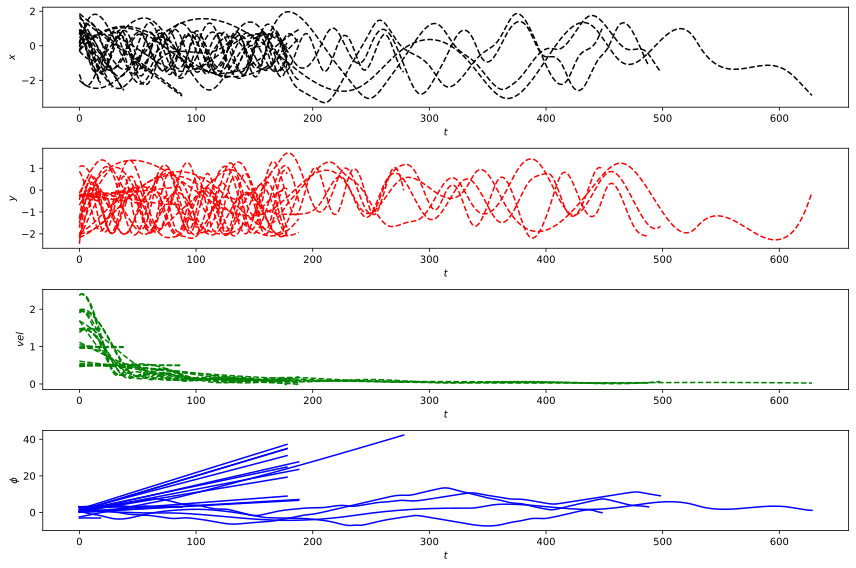

In [49]:
# Plot the data
fig, axs = plt.subplots(4, 1, tight_layout=True, figsize=(12, 8))
for i in range(len(X_train) - 3):
    x = X_train[i][:,0]
    y = X_train[i][:,1]
    phi = X_train[i][:,3]
    vel = X_train[i][:,2]
    delta = U_train[i][:,1]
    axs[0].plot(x, '--k')
    axs[1].plot(y, '--r')
    axs[2].plot(vel, '--g')
    axs[3].plot(phi, '-b')
    # axs[4].plot(delta, 'm')
axs[0].set(
        ylabel=r'$x$',
        xlabel=r'$t$')
axs[1].set(
        ylabel=r'$y$',
        xlabel=r'$t$')
axs[2].set(
        ylabel=r'$vel$',
        xlabel=r'$t$')
axs[3].set(
        ylabel=r'$\phi$',
        xlabel=r'$t$')

In [50]:
def EDMD_koopman(X0,Y0,U):
    X0 = np.vstack(X0) # Vertical stack of data runs
    Y0 = np.vstack(Y0)
    U0 = np.vstack(U)
    print(X0.shape,Y0.shape,U0.shape)
    # Get temporally shifted data matrix
    # X = X0[:-1,:]
    # Y = X0[1:,:]

    # Lifting of states
    X_lift = lift_states.lift_states(X0)
    Y_lift = lift_states.lift_states(Y0)
    print(X_lift.shape,Y_lift.shape,U0.shape)
    zt = X_lift
    zt_plus1 = Y_lift
    zt_control = np.row_stack((X_lift,U0.T)) # Stacking for left shifted control matrix
    print('Array shapes of zt, zt+1 and zt_control are',zt.shape,zt_plus1.shape,zt_control.shape)

    # Koopman A and B matrix by EDMD
    A_B = zt_plus1@zt_control.T@np.linalg.pinv(zt_control@zt_control.T) # Analytical solution for data snapshots
    A_edmd = np.round(A_B[:,:-2],4) # Get A matrix baring the last two columns for control matrix rounded
    B_edmd = np.round(A_B[:,-2:],4) # Get B matrix with the last two columns for control matrix rounded
    print(np.linalg.pinv(zt).shape)
    C_edmd =  np.round(X0.T@np.linalg.pinv(zt))
    return A_B,A_edmd,B_edmd, C_edmd

In [51]:
# Lift the system analytically to get A,B,C matrix from X_train data
from numpy import linalg as LA
AB, A_edmd, B_edmd, Cedmd =  EDMD_koopman(X_train,Y_train,U_train)
# print(Cedmd)
w, v = LA.eig(A_edmd)
print(AB.shape,A_edmd.shape,B_edmd.shape)

(5534, 4) (5534, 4) (5534, 2)
(15, 5534) (15, 5534) (5534, 2)
Array shapes of zt, zt+1 and zt_control are (15, 5534) (15, 5534) (17, 5534)
(5534, 15)
(15, 17) (15, 15) (15, 2)


50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


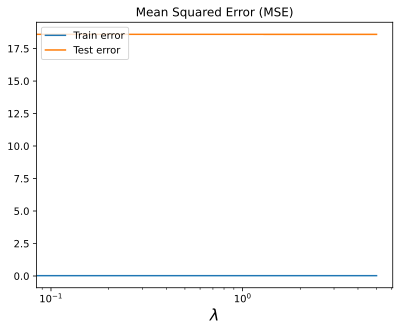

In [54]:
# Performing ridge regression to improve sparsity
# Import packages.
import cvxpy as cp
import numpy as np
from cvxpy.atoms.norm import norm

def loss_fn(X, Y, U, A,B):
    return norm(Y - A@ X - B@U, p='fro')**2

def regularizer(A):
    return cp.norm1(A)

def objective_fn(X, Y, U, A,B, lambd):
    return loss_fn(X, Y, U, A, B) + lambd * regularizer(A)

def mse(X, Y, U,A,B):
    return (1.0 / X.shape[1]) * loss_fn(X, Y, U, A, B).value

# Generate data.

U0_train = np.vstack(U_train).T
U0_test = np.vstack(U_test).T
X_train_lift = lift_states.lift_states(np.vstack(X_train))
Y_train_lift = lift_states.lift_states(np.vstack(Y_train))
X_test_lift = lift_states.lift_states(np.vstack(X_test))
Y_test_lift = lift_states.lift_states(np.vstack(Y_test))

# Fitting the model
# beta = cp.Variable(n)
A_edmd_ridge = cp.Variable((X_train_lift.shape[0],X_train_lift.shape[0]))
B_edmd_ridge = cp.Variable((X_train_lift.shape[0],2))
lambd = cp.Parameter(nonneg=True)
# lambd = 5
problem = cp.Problem(cp.Minimize(objective_fn(X_train_lift, Y_train_lift,U0_train, A_edmd_ridge, B_edmd_ridge, lambd)))
# problem.solve(solver=cp.SCS)

lambd_values = np.linspace(0, 5, 50)
print(len(lambd_values))
train_errors = []
test_errors = []
A_values = []
B_values = []
count = 0
for v in lambd_values:
    print(count)
    lambd.value = v
    problem.solve(solver=cp.SCS)
    train_errors.append(mse(X_train_lift, Y_train_lift, U0_train, A_edmd_ridge,B_edmd_ridge))
    test_errors.append(mse(X_test_lift, Y_test_lift, U0_test,A_edmd_ridge,B_edmd_ridge))
    A_values.append(A_edmd_ridge.value)
    B_values.append(B_edmd_ridge.value)
    count+=1
#
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
#
plot_train_test_errors(train_errors, test_errors, lambd_values)

# print(A_edmd_ridge.shape,B_edmd_ridge.shape)

In [58]:
A_edmd_ridge = np.array(A_values[10])
B_edmd_ridge = np.array(B_values[10])


Figure name not provided for save file


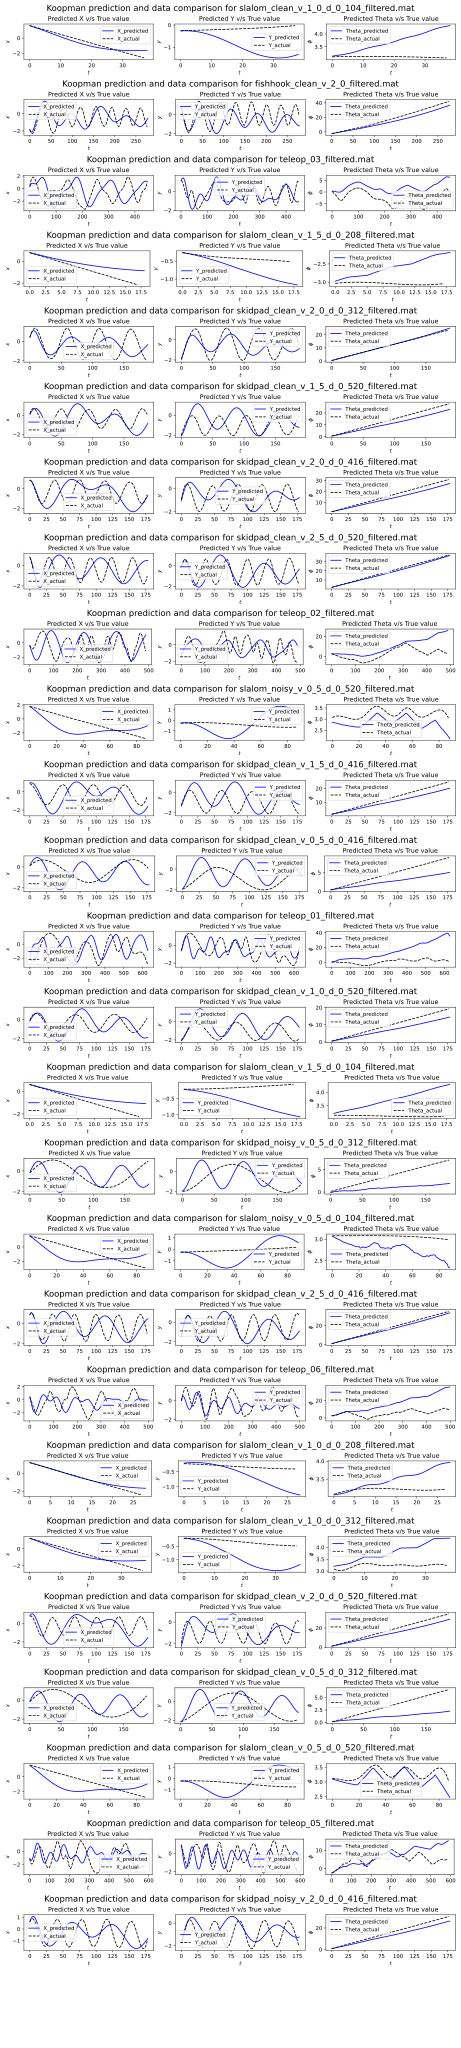

In [59]:
run_name = f_name
imsave_name = 'Koopman_edmd_training_prediction_ol_skidpad_teleop'
plotter_tools_ol.plot_lifted_predictions(X_train,A_edmd_ridge,B_edmd_ridge,U_train,run_name)

Figure name not provided for save file


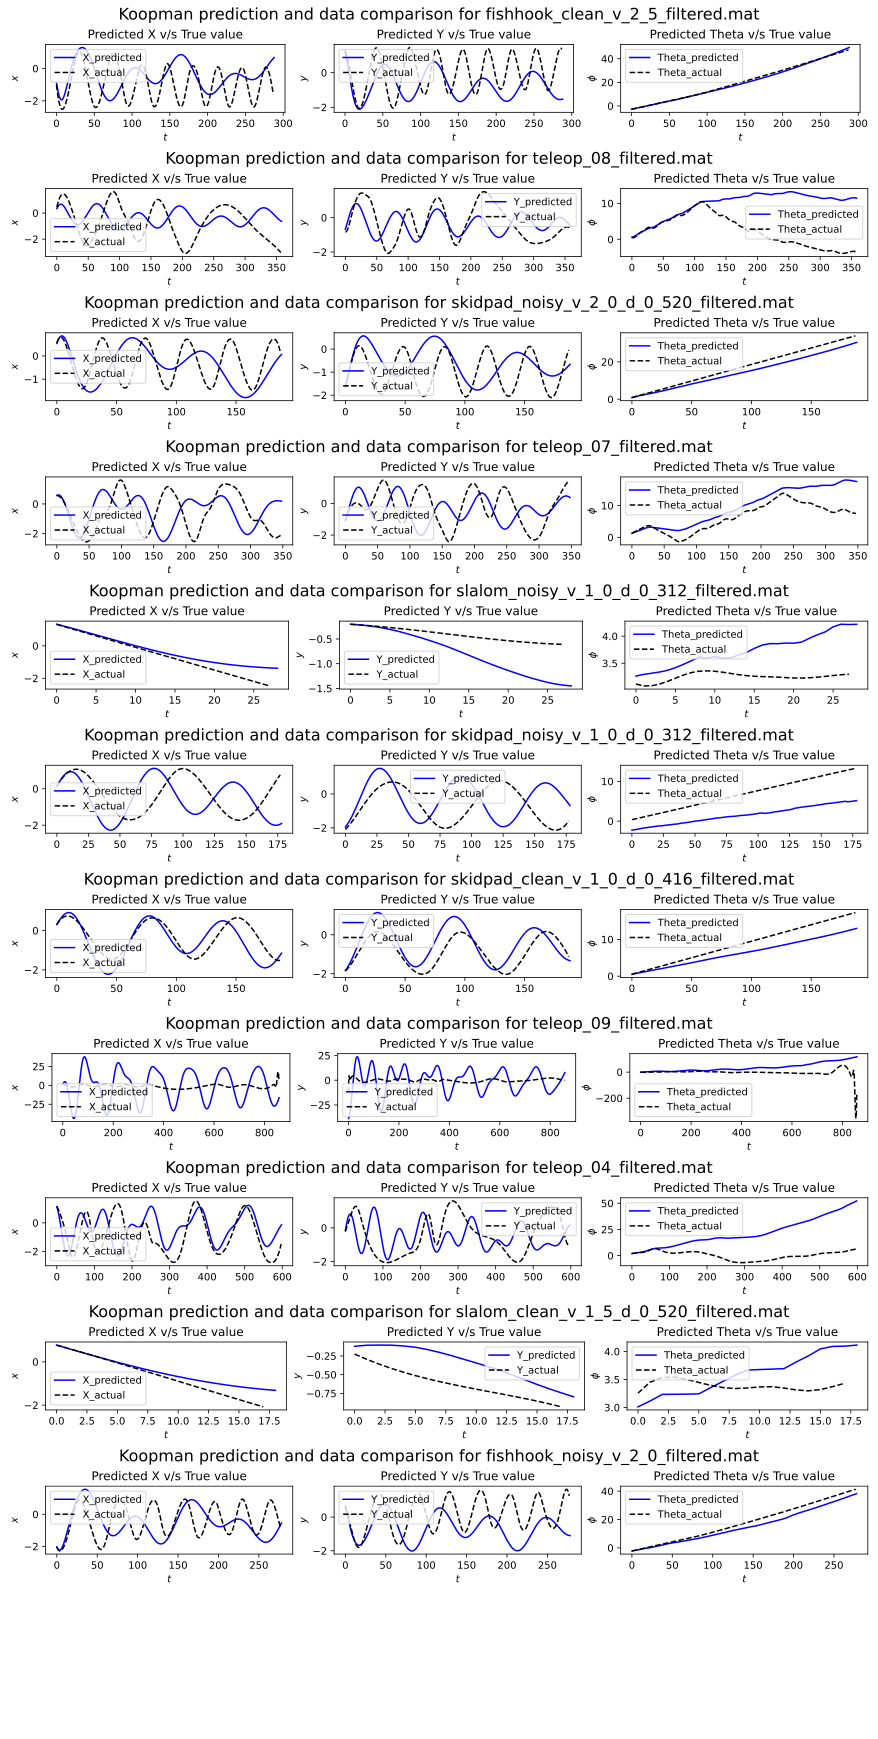

In [60]:
run_name = f_name_test
imsave_name = 'Koopman_edmd_test_prediction_ol_skidpad_teleop'
# print(X_test[5].shape)
plotter_tools_ol.plot_lifted_predictions(X_test,A_edmd_ridge,B_edmd_ridge,U_test,run_name)

In [61]:
def simulate_ol(A,B,C,X,u):
    zt = lift_states.lift_states(X) # Lifting the data in x
    z_prime = np.zeros((zt.shape[0],zt.shape[1]))
    u = u.T
    # z_prime[:,0] = zt[:,0]
    # print(A.shape,B.shape,X.shape,u.shape)
    z_prime[:,0] = A@zt[:,0] + B@u[:,0] #This is like the first value of Y array with 1st value of X and U
    for i in range(1,u.shape[1]):
            z_prime[:,i] = A@z_prime[:,i-1] + B@u[:,i] # Because X and U are one timestep behind Y, the U considered is ith iteration, also now we consider previous z_prime value

    x_hat_ = C@z_prime
    print(x_hat_.shape)
    return x_hat_

[-5]


Loading...: 100%|██████████| 158/158 [00:20<00:00,  7.55it/s]


(4, 189)
(4, 189)


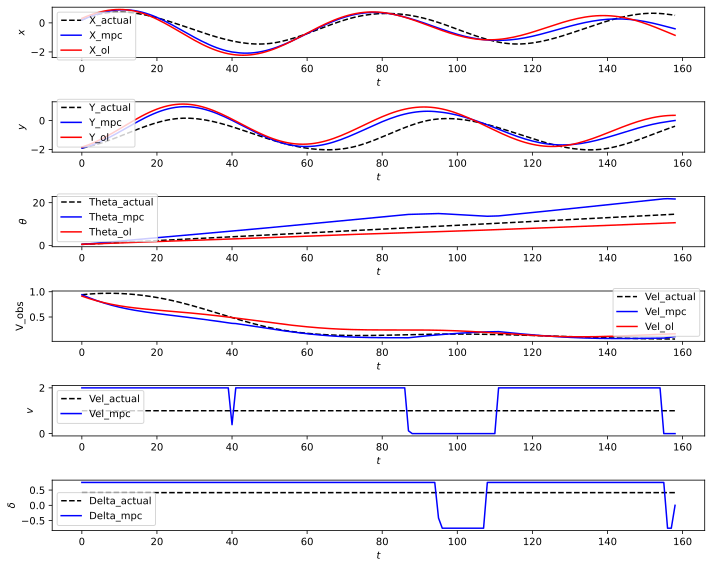

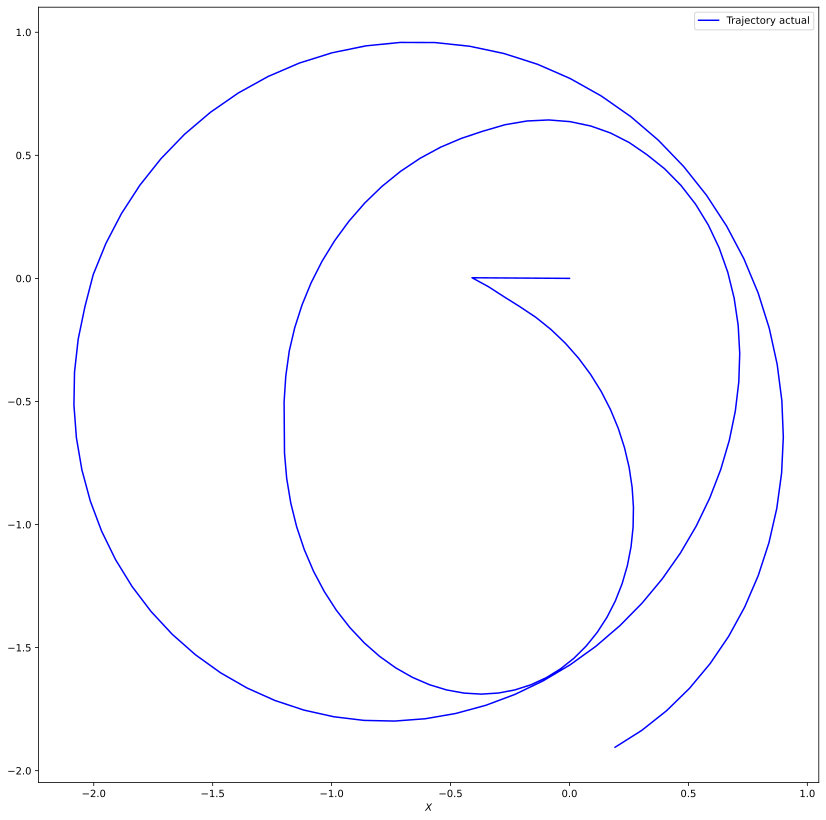

In [70]:
# Linear MPC with cvxpy
import cvxpy as cp
from cvxpy import reshape
from cvxopt import matrix
from tqdm import tqdm
import time
num = np.random.randint(0,len(X_test),1)
num = [-5]
save_fig = 'No'
print(num)
# Initialization
x_ref = X_test[num[0]]
z_ref = lift_states.lift_states(x_ref)
u_ref = U_test[num[0]].T
N = 30 # Prediction horizon

z_init = np.zeros((z_ref.shape[0],z_ref.shape[1]))
z_init[:,0] = z_ref[:,0]

u_mpc = np.zeros((u_ref.shape[0],u_ref.shape[1]))


Q = np.zeros((z_ref.shape[0],z_ref.shape[0]))
R = np.eye(2)
Q[1,1] = 5 ; Q[2,2] = 5; Q[3,3] = 1; Q[4,4] = 2
umin = np.array([0,-0.75]).reshape(2)
umax = np.array([2,0.75]).reshape(2)
count = 1
time_count = []


for count in tqdm(range(1,z_ref.shape[1] - N),desc="Loading..."): # Main loop for solver
    z_pred = cp.Variable((z_ref.shape[0], N + 1))
    u_pred = cp.Variable((u_ref.shape[0], N))
    z_ref_ = matrix(z_ref[:,count:count+N+1]) # z_ref_ is the reference window for the current iteration of the loop
    u_ref_ = matrix(u_ref[:,count-1:count+N])
    # print(z_ref_.shpe,u_ref_.shape)
    cost = 0 # Initializing cost before the loop
    constr = [] # Initializing constaint value
    for i in range(N):
        # print(i)
        # cost += cp.quad_form(reshape(z_pred[:,i+1],(21,1)) - z_ref_[:,i+1],Q) + cp.quad_form(reshape(u_pred[:,i],(2,1)) - u_ref_[:,i],R) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        # cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q)  # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        if i == 0:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        else:
            cost += cp.quad_form(reshape(z_pred[:,i+1],(z_ref.shape[0],1)) - z_ref_[:,i],Q) + cp.quad_form(reshape((u_pred[:,i]-u_pred[:,i-1])/0.5,(2,1)) ,np.eye(2)*2) # Quad prog required to do (x-x_ref).T@Q@(x-x_ref)
        constr += [z_pred[:, i + 1] == A_edmd_ridge @ z_pred[:, i] + B_edmd_ridge @ u_pred[:, i],umin <=u_pred[:,i], u_pred[:,i]<= umax]
        # except:
        #     print('Dimension mismatch')
    # sums problem objectives and concatenates constraints.
    constr += [z_pred[:, 0] == z_init[:,count-1]]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(solver=cp.SCS,verbose=False)
    # print(problem.solve())
    u_mpc[:,count-1] = u_pred.value[:,0]
    z_init[:,count] = A_edmd_ridge@z_init[:,count-1] + B_edmd_ridge@u_pred.value[:,0]
    # z_init[:,count] = reshape(z_ref_[:,0],(15,1))
    # count += 1
    # t1 = time.time()
    # t_diff = t1-t0
    # time_count.append(t_diff)


# plt.plot(time_count)
# print(u_mpc.shape)
#Get open loop response
x_hat_ol = simulate_ol(A_edmd_ridge,B_edmd_ridge,Cedmd,X_test[num[0]],U_test[num[0]])
print(x_hat_ol.shape)

#Plot all
fig, axs = plt.subplots(6, 1, tight_layout=True, figsize=(10, 8))
# axs[0].plot(y[4,:], '--r')
axs[0].plot(X_test[num[0]][:-N,0],'--k', label='X actual')
axs[0].plot(z_init[1,:-N],'b',label='X mpc')
axs[0].plot(x_hat_ol[0,:-N],'r',label='X ol')
axs[0].set(ylabel=r'$x$',xlabel=r'$t$')
axs[0].legend(['X_actual','X_mpc','X_ol'])

# test = np.arange(0,X_test[num[0]].shape[0])
# print(test)
axs[1].plot(X_test[num[0]][:-N,1],'--k', label='Y actual')
axs[1].plot(z_init[2,:-N],'b',label='Y mpc')
axs[1].plot(x_hat_ol[1,:-N],'r',label='Y ol')
axs[1].set(ylabel=r'$y$',xlabel=r'$t$')
axs[1].legend(['Y_actual','Y_mpc','Y_ol'])


axs[2].plot(X_test[num[0]][:-N,3],'--k', label='Theta actual')
axs[2].plot(z_init[4,:-N],'b',label='Theta mpc')
axs[2].plot(x_hat_ol[3,:-N],'r',label='Theta ol')
axs[2].set(ylabel=r'$\theta$',xlabel=r'$t$')
axs[2].legend(['Theta_actual','Theta_mpc','Theta_ol'])

axs[3].plot(X_test[num[0]][:-N,2],'--k', label='Velocity actual')
axs[3].plot(z_init[3,:-N],'b',label='Velocity mpc')
axs[3].plot(x_hat_ol[2,:-N],'r',label='Velocity ol')
axs[3].set(ylabel=r'V_obs',xlabel=r'$t$')
axs[3].legend(['Vel_actual','Vel_mpc','Vel_ol'])



axs[4].plot(U_test[num[0]][:-N,0],'--k', label='Vel actual')
axs[4].plot(u_mpc[0,:-N],'b',label='Vel mpc')
axs[4].set(ylabel=r'$v$',xlabel=r'$t$')
axs[4].legend(['Vel_actual','Vel_mpc'])

axs[5].plot(U_test[num[0]][:-N,1],'--k', label='Delta actual')
axs[5].plot(u_mpc[1,:-N],'b',label='Delta mpc')
axs[5].set(ylabel=r'$\delta$',xlabel=r'$t$')
axs[5].legend(['Delta_actual','Delta_mpc'])
file_name_strp = f_name_test[num[0]].split('.')
if save_fig == 'Yes':
    plt.savefig(file_name_strp[0]+'_plots')
    print('Figure_saved')



fig2 = plt.figure(figsize=(14,14))
# plt.plot(X_test[num[0]][:,0],X_test[num[0]][:,1],'--k', label='Trajectory actual')
plt.plot(z_init[1,:],z_init[2,:],'b',label='MPC trajectory')
plt.xlabel('$X$')
plt.ylabel=('$Y$')
plt.legend(['Trajectory actual','MPC trajectory'])
plt.savefig('MPC trajectory')